Q-Learning Example by Robert Meyer

In [2]:
# Imports
import numpy as np
from numpy.random import randint
import matplotlib.pyplot as plt
from matplotlib import animation
import pandas as pd
import time
from IPython import display

In [3]:
# Proper Matlab settings
%matplotlib inline
plt.rcParams["text.usetex"] = False
plt.rcParams["legend.numpoints"] = 1
plt.rcParams["figure.figsize"] = (9, 7)
plt.rcParams["figure.dpi"] = 70
plt.rcParams["savefig.dpi"] = plt.rcParams["figure.dpi"]
plt.rcParams["font.size"] = 17
plt.rcParams["pdf.fonttype"] = 42

The Problem Description
=======================

We will teach an Reinforcment Learning agent to find a goal in a maze.
The algorithm to generate the maze is taken from [Wikipedia](https://en.wikipedia.org/wiki/Maze_generation_algorithm).

The maze is defined by 0s (floor) and 1s (wall).
We will us a small 7x7 maze, but explore any size you want.

In [4]:
def maze(height=51, width=81, complexity=.75, density=.75):
    """Generates a maze"""
    # Only odd shapes
    shape = ((height // 2) * 2 + 1, (width // 2) * 2 + 1)
    # Adjust complexity and density relative to maze size
    complexity = int(complexity * (5 * (shape[0] + shape[1])))
    density    = int(density * ((shape[0] // 2) * (shape[1] // 2)))
    # Build actual maze
    Z = np.zeros(shape, dtype=int)
    # Fill borders
    Z[0, :] = Z[-1, :] = 1
    Z[:, 0] = Z[:, -1] = 1
    # Make aisles
    for i in range(density):
        x, y = randint(0, shape[1] // 2) * 2, randint(0, shape[0] // 2) * 2
        Z[y, x] = 1
        for j in range(complexity):
            neighbours = []
            if x > 1:             neighbours.append((y, x - 2))
            if x < shape[1] - 2:  neighbours.append((y, x + 2))
            if y > 1:             neighbours.append((y - 2, x))
            if y < shape[0] - 2:  neighbours.append((y + 2, x))
            if len(neighbours):
                y_,x_ = neighbours[randint(0, len(neighbours))]
                if Z[y_, x_] == 0:
                    Z[y_, x_] = 1
                    Z[y_ + (y - y_) // 2, x_ + (x - x_) // 2] = 1
                    x, y = x_, y_
    return Z


def check(maze, state):
    """Checks if state can be reached (True) or if it is part of the wall (False)"""
    if maze[state[0], state[1]] == 0:
        return True
    else:
        return False
    

# Seed to generate maze
np.random.seed(1432)
# Create a small maze
mymaze = maze(7, 7)
# Define the goal area
goal = (5, 5)
# Sanity check that goal can be reached:
assert check(mymaze, goal), 'Goal cannot be reached, pick another goal location!'

Let us plot the maze and the goal area (blue star):

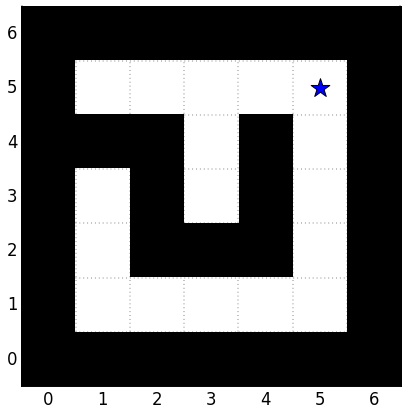

In [5]:
def plot_maze(maze, goal):
    plt.imshow(maze, cmap=plt.cm.binary, interpolation='nearest', origin='lower')
    #pyplot.xticks([]), pyplot.yticks([])
    major_xticks = np.arange(maze.shape[1])  
    major_yticks = np.arange(mymaze.shape[0])
    ax = plt.gca()
    ax.set_xticks(major_xticks+0.5, minor=True)                                                       
    ax.set_yticks(major_yticks+0.5, minor=True)   
    plt.grid(which='minor')
    ax.set_xticks(major_xticks)                                                       
    ax.set_yticks(major_yticks) 
    plt.scatter(goal[1], goal[0], c='b', marker='*', s=411)
    #plt.scatter(pos[1], pos[0], c='k', marker='x', s=299)
    plt.xlim(-0.5, maze.shape[1]-0.5)
    plt.ylim(-0.5, maze.shape[0]-0.5)
    
    
plot_maze(mymaze, goal)

Q-Learning
==========

We will train an agent to find the optimal path to the goal from anywhere within the maze.

We will use the following Q-Learning rule:
\begin{align}
Q_{t+1}(s_t,a_t) \leftarrow r(s_t,a_t) + \beta \; \max_{a'}Q_{t}(s_{t+1}, a'),
\end{align}

where $a$ denotes an action, $s$ is a state, i.e. the agents position, $\beta$ is the discount factor, $r$ is the reward function and $t$ marks the current time step.

States are given by the row and column coordinates of the maze, for example the goal can be found at (5,5).

Possible actions include "Left", "Right", "Up", "Down" and "Stay", i.e. not moving within a time step.

We will give a reward of 100 for moving into the goal as well as staying in the goal.



Initialzing the System
----------------------

We will initialize the Q-table with zeros. Note that we filter the potential actions according to the states such that the RL-agent does not bounce into a wall. For example, in state (1,5) the agent can only decide to "Stay", move "Up", or go "Left".

In [6]:
def init_agent(maze):
    """Initailizes the Q-Learning agent.
    
    :return:
        1. A DataFrame containing the state transitions
        2. A DataFrame containing the rewards for each state action pair
                0 for most pairs but 100 for moving into and staying in the goal
        3. The Q-Table initialized with 0 and NaN for impossible state action pairs
        4. A dictionary containing all possible actions in each state 
            (to exclude actions that would drive the agent into a wall)
    """
    # Find all reachable states (i.e. exclude all walls)
    states = [(y,x) for x in range(maze.shape[1]) for y in range(maze.shape[0]) if maze[y,x] == 0]
    # Define all actions in terms of their relative coordingate changes
    actions = {'Left': (0,-1),
               'Right': (0,1),
               'Up': (1,0),
               'Down': (-1,0),
               'Stay':(0,0)}
    
    # Dictionary containing all possible action per state
    state_actions = {} 
    # DataFrame mapping state action pairs to the following states
    state_transitions = pd.DataFrame(index=states, columns=actions.keys(), dtype=object)
    # DataFrame mapping state action pairs to the corresponding rewards
    rewards = pd.DataFrame(index=states, columns=actions.keys(), dtype=float)
    # DataFrame mapping state action pairs to the corresponding Q-values
    q_table = pd.DataFrame(index=states, columns=actions.keys(), dtype=float, data=np.NaN)

    # Iterate throug all state action pairs, exclude impossible actions,
    # initialize q-values and set rewards
    for state in states:
        state_actions[state] = []
        for action in sorted(actions.keys()):
            value = actions[action]
            new_state = (state[0] + value[0], state[1] + value[1])
            reward=0
            if new_state in states:
                if new_state == goal:
                    # Give 100 reward if action ends up in goal
                    reward = 100
                state_actions[state].append(action)
                rewards.loc[state, action] = reward
                state_transitions.loc[state, action] = new_state
                q_table.loc[state, action] = 0

    return state_transitions, rewards, q_table, state_actions

Q-Learning Functions
--------------------

The following functions can be iteratively applied to enable Q-Learning.
The agent needs to select a new action and then perfrom a `move`. 
Moving includes updating the Q-Table.

    

In [7]:
def update_q(state, action, next_state, state_transitions, rewards, q_table, beta):
    """Performs one Q-Table update"""
    reward = rewards.get_value(state, action)
    maxQ = np.nanmax(q_table.loc[[next_state], :].values)
    newQ = reward + beta * maxQ
    q_table.loc[[state], action] = newQ
    return q_table


def select_random_action(current_state, state_actions):
    """Selects a random action in the `current_state`"""
    return np.random.choice(state_actions[current_state])


def move(current_state, action, state_transitions, rewards, q_table, beta):
    """Moves to the next state and updates the Q-table"""
    next_state = state_transitions.get_value(current_state, action)
    q_table = update_q(current_state, action, next_state, state_transitions, rewards, q_table, beta)
    return next_state

Plotting Progress
-----------------
Down below you find a helper class to plot the progress of the Q-Learner over time.
The agent's current position is marked by a big X.
The current best Q-Value in each state is depicted by a green circle.
The size of the circle depends on the magnitude of the Q-value. The bigger the better!

In [8]:
class AnimationPlotter(object):
    def __init__(self):
        self.sc = None
        self.scpos = None
        self.frames = []
        
    def record_frame(self, maze, goal, state, action, next_state, q_table):
        """Records snapshots of the agents trajectory for animation"""
        self.frames.append((maze, goal, state, action, next_state, q_table.copy()))

    def plot_with_q_table(self, maze, goal, pos, q_table):
        """Plots a single Update Step including the Q-values"""
        if self.sc is None:
            plot_maze(maze, goal)
        states = list(zip(*q_table.index.values))
        bestQs = np.nanmax(q_table.values, axis=1)*10
        if self.sc is None:
            self.sc = plt.scatter(states[1], states[0], s=bestQs, c='g', alpha=0.5)
        else:
            self.sc._sizes = bestQs
        
        if self.scpos is None:
            self.scpos = plt.scatter(pos[1], pos[0], c='k', marker='x', s=299, linewidth='3')
            self.new=False
        else:
            self.scpos.set_offsets([pos[1], pos[0]])
        
    def _animate(self, irun, interval, end=False):
        maze, goal, state, action, next_state, q_table = self.frames[irun]
        self.plot_with_q_table(maze, goal, state, q_table)
        q_value = q_table.get_value(state, action)
        plt.title('Iteration %d, performed "%s" \nwith Q-value %.2f' % (irun, action, q_value))
        plt.pause(interval)
        display.clear_output(wait=True)
        if not end:
            display.display(plt.gcf())
        
    def show_animation(self, interval=0.1):
        """Shows and animation"""
        self.sc = None
        self.scpos = None
        for irun in range(len(self.frames)):
            self._animate(irun, interval)
        self._animate(irun, interval, end=True)

Main Script
-----------

Below you find the main script that iteratively applies Q-learning.
Let's first start with the initial setting:

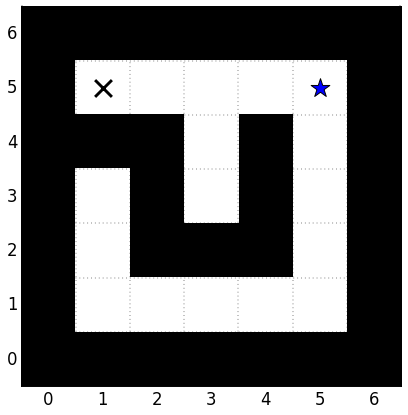

In [9]:
# Initialize the system
state_transitions, rewards, q_table, state_actions = init_agent(mymaze)
# Q-Learnign Parameters
np.random.seed(42) # Random Seed for fixed trajectory
current_state = (5,1) # Starting Location
beta=0.5 # Discount Factor
steps = 200 # Number of time steps

# Helper class for animation
a = AnimationPlotter()
# Lets see the initial state:
a.plot_with_q_table(mymaze, goal, current_state, q_table)

Next let's run the q-learning for a couple of steps.
The animation is given in the next cell below.

In [10]:
# Iteratively apply Q-Learning
for irun in range(steps):
    # Select a random action
    action = select_random_action(current_state, state_actions)
    # Move and upate q-table
    next_state = move(current_state, action, state_transitions, rewards, q_table, beta)
    
    # Record progress and new Q-value of the state action pair
    a.record_frame(mymaze, goal, current_state, action, next_state, q_table)
    
    # Update current state
    current_state = next_state

Let's see the animation:

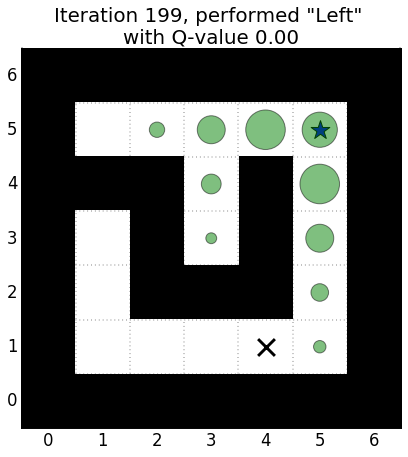

In [11]:
a.show_animation()

Let's take a look at the Q-table. There are still a lot of 0s in there:

In [12]:
q_table

,Right,Stay,Left,Up,Down
"(1, 1)",0.0000,0.00000,NaN,0.00000,NaN
"(2, 1)",NaN,0.00000,NaN,0.00000,0.000000
"(3, 1)",NaN,0.00000,NaN,NaN,0.000000
"(5, 1)",0.0000,0.00000,NaN,NaN,NaN
"(1, 2)",0.0000,0.00000,0.00000,NaN,NaN
"(5, 2)",25.0000,0.00000,0.00000,NaN,NaN
"(1, 3)",0.0000,0.00000,0.00000,NaN,NaN
"(3, 3)",NaN,6.25000,NaN,12.50000,NaN
"(4, 3)",NaN,12.50000,NaN,41.40625,6.250000
"(5, 3)",82.8125,41.40625,0.00000,NaN,12.500000


Let's run a couple of more iterations and plot the cumulative Q-values over time.
They will converge eventually.

In [13]:
for irun in range(3000):
    action = select_random_action(current_state, state_actions)
    next_state = move(current_state, action, state_transitions, rewards, q_table, beta)
    mean_q = np.nansum(q_table.values)
    current_state = next_state
    print('\r Iteration %d, sum of q_values %.2f' % (irun, mean_q), end='')

 Iteration 2999, sum of q_values 1899.22

If we know look at the final state, we can spot the optimal trajectory.
Just follow the green dots in the increasing direction to end up in the goal from anywhere in the maze:

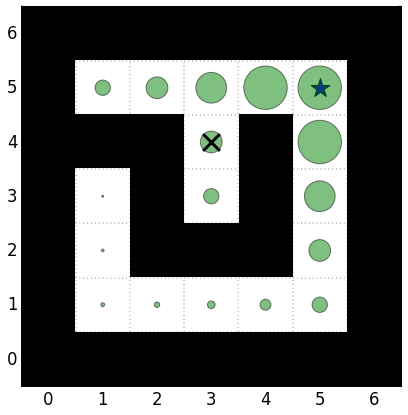

In [14]:
AnimationPlotter().plot_with_q_table(mymaze, goal, next_state, q_table)

The corresponding Q.table is given below:

In [15]:
q_table

,Right,Stay,Left,Up,Down
"(1, 1)",1.5625,0.781250,NaN,0.390625,NaN
"(2, 1)",NaN,0.390625,NaN,0.195312,0.781250
"(3, 1)",NaN,0.195312,NaN,NaN,0.390625
"(5, 1)",25.0000,12.500000,NaN,NaN,NaN
"(1, 2)",3.1250,1.562500,0.78125,NaN,NaN
"(5, 2)",50.0000,25.000000,12.50000,NaN,NaN
"(1, 3)",6.2500,3.125000,1.56250,NaN,NaN
"(3, 3)",NaN,12.500000,NaN,25.000000,NaN
"(4, 3)",NaN,25.000000,NaN,50.000000,12.500000
"(5, 3)",100.0000,50.000000,25.00000,NaN,25.000000
